## Environment

In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pybedtools
from pybedtools import BedTool
import glob
from matplotlib_venn import venn2, venn3
import matplotlib.patches as mpatches
from adjustText import adjust_text
from upsetplot import from_memberships, plot

In [33]:
os.chdir("/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Federica_ATAC/")

In [34]:
# Set the aesthetics for the plots
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("white")

# Define the paths
DIFFBIND_DIR = "results/diffbind"
PEAKS_DIR = "results/peaks"
OUTPUT_DIR = "analysis_output"


In [35]:
# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Define functions

In [36]:
def load_diffbind_results(comparison):
    file_path = os.path.join(DIFFBIND_DIR, comparison, "differential_peaks.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        # Add a column to identify the comparison
        df['comparison'] = comparison
        return df
    else:
        print(f"Warning: {file_path} does not exist")
        return None

In [37]:
def create_volcano_plot(df, comparison, output_dir, pval_threshold=0.05, lfc_threshold=2):
    if df is None or df.empty:
        print(f"No data available for {comparison}")
        return
    
    # Create a new figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Calculate -log10 of p-values
    df['-log10(p-value)'] = -np.log10(df['p.value'])
    
    # Determine colors based on significance and fold change
    df['color'] = 'grey'  # Default color
    df.loc[(df['p.value'] < pval_threshold) & (df['Fold'] > lfc_threshold), 'color'] = 'red'  # Upregulated
    df.loc[(df['p.value'] < pval_threshold) & (df['Fold'] < -lfc_threshold), 'color'] = 'blue'  # Downregulated
    
    # Create the scatter plot
    ax.scatter(df['Fold'], df['-log10(p-value)'], c=df['color'], alpha=0.6, s=30)
    
    # Add lines for thresholds
    ax.axhline(-np.log10(pval_threshold), color='gray', linestyle='--')
    ax.axvline(lfc_threshold, color='gray', linestyle='--')
    ax.axvline(-lfc_threshold, color='gray', linestyle='--')
    
    # Add labels for some of the most significant points
    texts = []
    for idx, row in df.sort_values('p.value').head(10).iterrows():
        # Create a label with chromosome and position
        label = f"{row['seqnames']}:{row['start']}-{row['end']}"
        texts.append(ax.text(row['Fold'], -np.log10(row['p.value']), label, fontsize=8))
    
    # Adjust text to avoid overlapping
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))
    
    # Add legend
    red_patch = mpatches.Patch(color='red', label='Upregulated')
    blue_patch = mpatches.Patch(color='blue', label='Downregulated')
    grey_patch = mpatches.Patch(color='grey', label='Not significant')
    ax.legend(handles=[red_patch, blue_patch, grey_patch], loc='upper right')
    
    # Add labels and title
    ax.set_xlabel('Log2 Fold Change')
    ax.set_ylabel('-log10(p-value)')
    ax.set_title(f'Volcano Plot - {comparison}')
    
    # Save the figure
    output_file = os.path.join(output_dir, f"{comparison}_volcano_plot.png")
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    print(f"Volcano plot saved to {output_file}")
    
    # Return summary statistics
    significant = df[df['p.value'] < pval_threshold]
    upregulated = significant[significant['Fold'] > lfc_threshold]
    downregulated = significant[significant['Fold'] < -lfc_threshold]
    
    plt.show()
    plt.close(fig)
    
    return {
        'total': len(df),
        'significant': len(significant),
        'upregulated': len(upregulated),
        'downregulated': len(downregulated)
    }

In [38]:
def create_ma_plot(df, comparison, output_dir):
    if df is None or df.empty:
        print(f"No data available for {comparison}")
        return
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Calculate average concentration
    df['AveExpr'] = (df['Conc_WT'] + df[f"Conc_{comparison.split('_')[0]}"]) / 2
    
    # Determine colors based on significance
    df['color'] = 'grey'  # Default color
    df.loc[df['FDR'] < 0.05, 'color'] = 'red'  # Significant
    
    # Create the scatter plot
    ax.scatter(df['AveExpr'], df['Fold'], c=df['color'], alpha=0.6, s=30)
    
    # Add a horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # Add labels and title
    ax.set_xlabel('Average Expression')
    ax.set_ylabel('Log2 Fold Change')
    ax.set_title(f'MA Plot - {comparison}')
    
    # Add legend
    red_patch = mpatches.Patch(color='red', label='FDR < 0.05')
    grey_patch = mpatches.Patch(color='grey', label='Not significant')
    ax.legend(handles=[red_patch, grey_patch], loc='upper right')
    
    # Save the figure
    output_file = os.path.join(output_dir, f"{comparison}_ma_plot.png")
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    print(f"MA plot saved to {output_file}")
    
    # Display the plot
    plt.show()
    plt.close(fig)

In [39]:
def create_heatmap(df, comparison, output_dir, top_n=50):
    if df is None or df.empty:
        print(f"No data available for {comparison}")
        return
    
    # Get the top N differential peaks by p-value
    top_peaks = df.sort_values('p.value').head(top_n)
    
    # Create a heatmap of the fold changes
    fig, ax = plt.subplots(figsize=(10, 12))
    
    # Create a new dataframe for the heatmap
    heatmap_data = pd.DataFrame({
        'Peak': [f"{row['seqnames']}:{row['start']}-{row['end']}" for _, row in top_peaks.iterrows()],
        'Log2FC': top_peaks['Fold'],
        '-log10(p-value)': -np.log10(top_peaks['p.value'])
    })
    
    # Set the peak as the index
    heatmap_data = heatmap_data.set_index('Peak')
    
    # Create the heatmap
    sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, annot=False, 
                linewidths=0.5, yticklabels=True, ax=ax)
    
    ax.set_title(f'Top {top_n} Differential Peaks - {comparison}')
    plt.tight_layout()
    
    # Save the figure
    output_file = os.path.join(output_dir, f"{comparison}_top_peaks_heatmap.png")
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    print(f"Heatmap saved to {output_file}")
    
    # Display the plot
    plt.show()
    plt.close(fig)

In [41]:
# Function to compare peaks between conditions
def compare_peaks(peak_files, output_dir):
    # Load all peak files
    peak_dfs = {}
    for sample in peak_files:
        peak_dfs[sample] = load_peak_files(sample)
    
    # Create BED files for each sample
    bed_files = {}
    for sample, df in peak_dfs.items():
        if df is not None and not df.empty:
            bed_file = os.path.join(output_dir, f"{sample}_peaks.bed")
            df[['chrom', 'start', 'end']].to_csv(bed_file, sep='\t', header=False, index=False)
            bed_files[sample] = bed_file
    
    # Create BedTool objects
    bed_tools = {sample: BedTool(file) for sample, file in bed_files.items()}
    
    # Compare peaks between samples (pairwise)
    for i, (sample1, bed1) in enumerate(bed_tools.items()):
        for sample2, bed2 in list(bed_tools.items())[i+1:]:
            # Find overlapping peaks
            overlap = bed1.intersect(bed2, wa=True)
            
            # Count overlapping peaks
            overlap_count = len(overlap)
            
            # Calculate Jaccard index
            jaccard = bed1.jaccard(bed2)
            
            print(f"Comparison between {sample1} and {sample2}:")
            print(f"  Overlapping peaks: {overlap_count}")
            print(f"  Jaccard index: {jaccard['jaccard']}")
    
    # Create Venn diagrams for groups
    # Group samples by condition
    conditions = {}
    for sample in peak_files:
        condition = sample.split('-')[0]  # Assuming format like "WT1-ATAC"
        if condition not in conditions:
            conditions[condition] = []
        conditions[condition].append(sample)
    
    # Create a Venn diagram for each pair of conditions
    for i, (cond1, samples1) in enumerate(conditions.items()):
        for cond2, samples2 in list(conditions.items())[i+1:]:
            # Merge peaks within each condition
            merged_bed1 = None
            for sample in samples1:
                if sample in bed_tools:
                    if merged_bed1 is None:
                        merged_bed1 = bed_tools[sample]
                    else:
                        merged_bed1 = merged_bed1.cat(bed_tools[sample], postmerge=True)
            
            merged_bed2 = None
            for sample in samples2:
                if sample in bed_tools:
                    if merged_bed2 is None:
                        merged_bed2 = bed_tools[sample]
                    else:
                        merged_bed2 = merged_bed2.cat(bed_tools[sample], postmerge=True)
            
            if merged_bed1 is not None and merged_bed2 is not None:
                # Count peaks in each set
                count1 = len(merged_bed1)
                count2 = len(merged_bed2)
                
                # Count overlapping peaks
                overlap = merged_bed1.intersect(merged_bed2, wa=True)
                overlap_count = len(overlap)
                
                # Create Venn diagram
                plt.figure(figsize=(8, 8))
                venn2(subsets=(count1 - overlap_count, count2 - overlap_count, overlap_count),
                      set_labels=(cond1, cond2))
                plt.title(f'Peak Overlap between {cond1} and {cond2}')
                
                # Save the figure
                output_file = os.path.join(output_dir, f"{cond1}_vs_{cond2}_venn.png")
                plt.savefig(output_file, dpi=300, bbox_inches='tight')
                print(f"Venn diagram saved to {output_file}")

                # Display the plot
                plt.show()
                plt.close()

In [42]:
# Function to create an UpSet plot for peak overlaps
def create_upset_plot(peak_files, output_dir):
    # Load all peak files
    peak_dfs = {}
    for sample in peak_files:
        peak_dfs[sample] = load_peak_files(sample)
    
    # Create BED files for each sample
    bed_files = {}
    for sample, df in peak_dfs.items():
        if df is not None and not df.empty:
            bed_file = os.path.join(output_dir, f"{sample}_peaks.bed")
            df[['chrom', 'start', 'end']].to_csv(bed_file, sep='\t', header=False, index=False)
            bed_files[sample] = bed_file
    
    # Create BedTool objects
    bed_tools = {sample: BedTool(file) for sample, file in bed_files.items()}
    
    # Group samples by condition
    conditions = {}
    for sample in peak_files:
        condition = sample.split('-')[0]  # Assuming format like "WT1-ATAC"
        if condition not in conditions:
            conditions[condition] = []
        conditions[condition].append(sample)
    
    # Merge peaks within each condition
    merged_beds = {}
    for cond, samples in conditions.items():
        merged_bed = None
        for sample in samples:
            if sample in bed_tools:
                if merged_bed is None:
                    merged_bed = bed_tools[sample]
                else:
                    merged_bed = merged_bed.cat(bed_tools[sample], postmerge=True)
        if merged_bed is not None:
            merged_beds[cond] = merged_bed
    
    # Create a universe of all peaks
    all_peaks = None
    for bed in merged_beds.values():
        if all_peaks is None:
            all_peaks = bed
        else:
            all_peaks = all_peaks.cat(bed, postmerge=True)
    
    if all_peaks is None:
        print("No peaks found in any sample")
        return
    
    # Create a dictionary to store peak memberships
    memberships = {cond: set() for cond in merged_beds.keys()}
    
    # For each peak in the universe, check which conditions it belongs to
    for i, peak in enumerate(all_peaks):
        peak_str = f"{peak.chrom}:{peak.start}-{peak.end}"
        for cond, bed in merged_beds.items():
            if len(bed.intersect(BedTool([peak]), u=True)) > 0:
                memberships[cond].add(peak_str)
    
    # Create the UpSet plot
    plt.figure(figsize=(12, 8))
    upset_data = from_memberships(memberships)
    plot(upset_data, sort_by='cardinality')
    plt.title('Peak Overlap between Conditions')
    
    # Save the figure
    output_file = os.path.join(output_dir, "peak_overlap_upset.png")
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    # Display the plot
    plt.show()
    plt.close()
    
    print(f"UpSet plot saved to {output_file}")


In [43]:
def create_pca_plot(peak_files, output_dir):
    """
    Create a PCA plot of samples based on peak intensity data.
    
    Args:
        peak_files: List of sample names for which peak files exist
        output_dir: Directory to save the output plot
    """
    print("Creating PCA plot of samples based on peak intensity...")
    
    # Create a count matrix from the peak files
    # First, create a union of all peaks
    all_peaks = None
    sample_peak_dfs = {}
    
    # Load all peak files
    for sample in peak_files:
        df = load_peak_files(sample)
        if df is not None and not df.empty:
            sample_peak_dfs[sample] = df
            
            # Convert to BedTool
            bed_file = os.path.join(output_dir, f"{sample}_peaks.bed")
            df[['chrom', 'start', 'end']].to_csv(bed_file, sep='\t', header=False, index=False)
            
            if all_peaks is None:
                all_peaks = pybedtools.BedTool(bed_file)
            else:
                all_peaks = all_peaks.cat(pybedtools.BedTool(bed_file), postmerge=True)
    
    if all_peaks is None:
        print("No peaks found in any sample")
        return
    
    # Create a merged peak file
    merged_peaks_file = os.path.join(output_dir, "merged_peaks.bed")
    all_peaks = all_peaks.sort().merge()
    all_peaks.saveas(merged_peaks_file)
    
    # Create a count matrix
    count_matrix = pd.DataFrame(index=range(len(all_peaks)))
    
    # Add coordinates to the count matrix
    coords = []
    for i, peak in enumerate(all_peaks):
        coords.append(f"{peak.chrom}:{peak.start}-{peak.end}")
    count_matrix['coordinates'] = coords
    count_matrix = count_matrix.set_index('coordinates')
    
    # For each sample, count reads in each peak
    for sample in peak_files:
        if sample in sample_peak_dfs:
            # Get the filtered BAM file path
            bam_file = f"results/bam/{sample}.filtered.bam"
            
            if os.path.exists(bam_file):
                # Count reads in each peak
                counts = []
                bam = pybedtools.BedTool(bam_file)
                
                for peak in all_peaks:
                    peak_bed = pybedtools.BedTool([peak])
                    overlap = bam.intersect(peak_bed, c=True)
                    count = int(str(overlap[0]).strip().split('\t')[-1])
                    counts.append(count)
                
                count_matrix[sample] = counts
            else:
                print(f"Warning: BAM file {bam_file} not found")
    
    # Save the count matrix
    count_matrix.to_csv(os.path.join(output_dir, "peak_count_matrix.csv"))
    
    # Perform PCA
    if len(count_matrix.columns) < 2:
        print("Not enough samples for PCA")
        return
    
    # Normalize counts (log2 transform with pseudocount)
    normalized_counts = np.log2(count_matrix.values + 1)
    
    # Run PCA
    pca = stats.PCA(n_components=2)
    pca_result = pca.fit_transform(normalized_counts.T)
    
    # Create a dataframe with PCA results
    pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    pca_df['sample'] = count_matrix.columns
    
    # Add condition information
    pca_df['condition'] = [sample.split('-')[0] for sample in pca_df['sample']]
    
    # Create the PCA plot
    plt.figure(figsize=(10, 8))
    
    # Create a color palette for conditions
    conditions = pca_df['condition'].unique()
    palette = sns.color_palette("Set1", n_colors=len(conditions))
    color_dict = dict(zip(conditions, palette))
    
    # Plot each point
    for condition in conditions:
        subset = pca_df[pca_df['condition'] == condition]
        plt.scatter(subset['PC1'], subset['PC2'], 
                   label=condition, 
                   color=color_dict[condition],
                   s=100, alpha=0.7)
    
    # Add sample labels
    for i, row in pca_df.iterrows():
        plt.annotate(row['sample'], 
                    (row['PC1'], row['PC2']),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=10)
    
    # Add axis labels with variance explained
    variance_explained = pca.explained_variance_ratio_ * 100
    plt.xlabel(f'PC1 ({variance_explained[0]:.2f}%)')
    plt.ylabel(f'PC2 ({variance_explained[1]:.2f}%)')
    
    # Add legend and title
    plt.legend(title='Condition')
    plt.title('PCA of ATAC-seq Samples')
    plt.grid(True, alpha=0.3)
    
    # Add a tight layout
    plt.tight_layout()
    
    # Save the figure
    output_file = os.path.join(output_dir, "pca_plot.png")
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    
    # Display the plot
    plt.show()
    plt.close()
    
    print(f"PCA plot saved to {output_file}")
    
    # Also save the PCA data
    pca_df.to_csv(os.path.join(output_dir, "pca_data.csv"), index=False)
    
    return pca_df

## Run analysis

In [44]:
print("Starting ATAC-seq/Cut&Tag analysis...")

# 1. Load differential binding results
print("\n1. Loading differential binding results...")
comparisons = ["KI_vs_WT", "KO_vs_WT", "PAZ_vs_WT"]
diff_results = {}
volcano_stats = {}

Starting ATAC-seq/Cut&Tag analysis...

1. Loading differential binding results...


In [45]:
for comparison in comparisons:
        diff_results[comparison] = load_diffbind_results(comparison)
        if diff_results[comparison] is not None:
            print(f"  Loaded {len(diff_results[comparison])} differential peaks for {comparison}") 

  Loaded 0 differential peaks for KI_vs_WT
  Loaded 17 differential peaks for KO_vs_WT
  Loaded 16563 differential peaks for PAZ_vs_WT


### PAZ_vs_WT

In [46]:
comparison = "PAZ_vs_WT"
df = diff_results[comparison]

In [47]:
df.head()

,seqnames,start,end,width,strand,Conc,Conc_PAZ,Conc_WT,Fold,p.value,FDR,comparison
0,1,44500940,44501340,401,*,6.420912,7.247757,4.276574,2.971183,4.320691e-11,0.000002,PAZ_vs_WT
1,3,37860398,37860798,401,*,6.453701,7.175678,4.941433,2.234245,2.541892e-10,0.000004,PAZ_vs_WT
2,6,98039864,98040264,401,*,6.940881,7.612090,5.646084,1.966007,3.800986e-10,0.000004,PAZ_vs_WT
3,2,5409880,5410280,401,*,6.730407,7.416652,5.375313,2.041339,4.901859e-10,0.000004,PAZ_vs_WT
4,13,112204893,112205293,401,*,6.257653,6.978767,4.749436,2.229331,7.068391e-10,0.000004,PAZ_vs_WT


Volcano plot saved to analysis_output/PAZ_vs_WT_volcano_plot.png


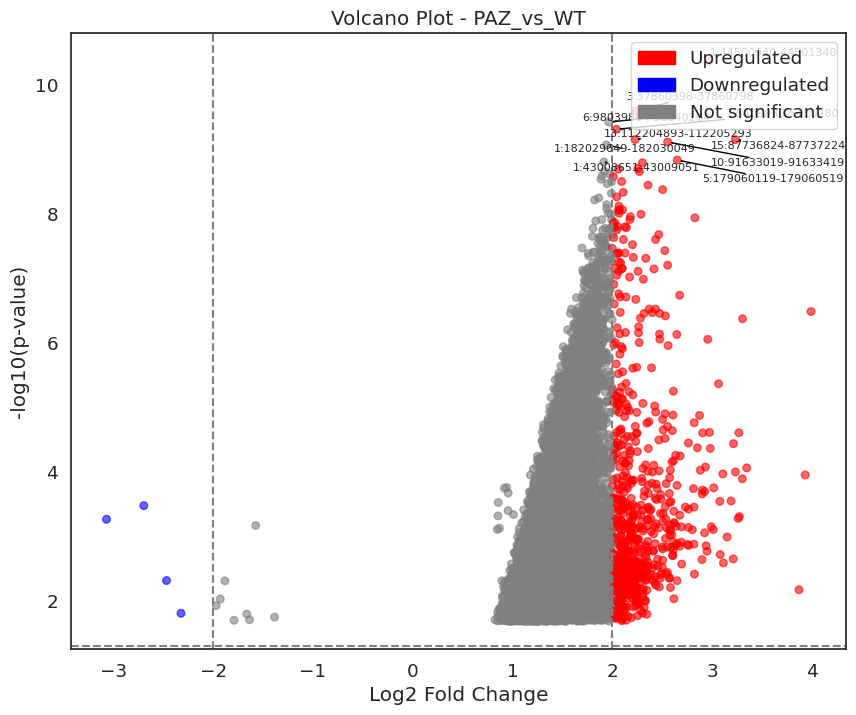

  PAZ_vs_WT: 16563 significant peaks (678 up, 4 down)


In [48]:
volcano_stats[comparison] = create_volcano_plot(df, comparison, OUTPUT_DIR)
if volcano_stats[comparison]:
    print(f"  {comparison}: {volcano_stats[comparison]['significant']} significant peaks " +
            f"({volcano_stats[comparison]['upregulated']} up, {volcano_stats[comparison]['downregulated']} down)")


MA plot saved to analysis_output/PAZ_vs_WT_ma_plot.png


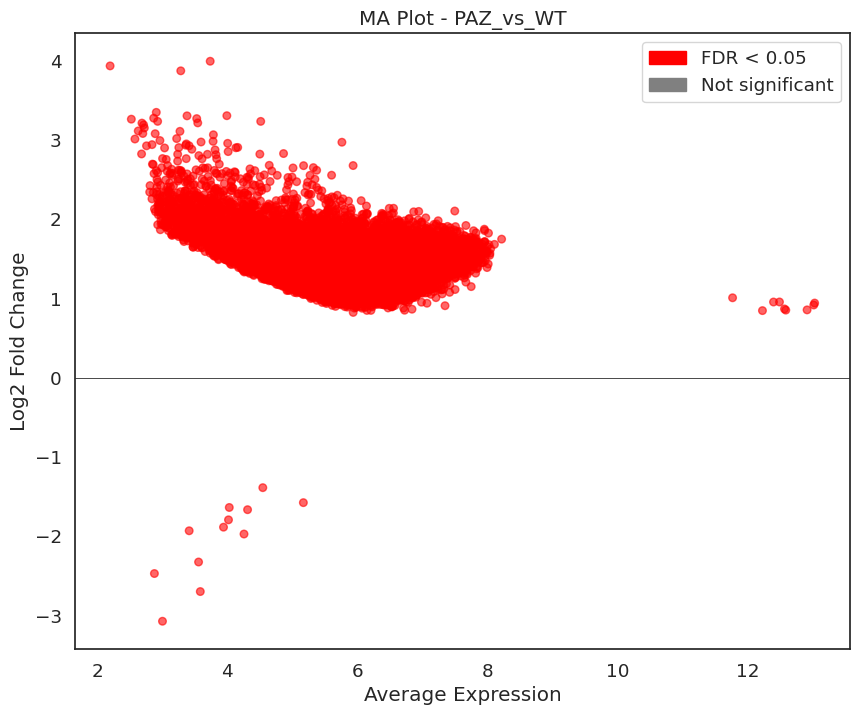

In [50]:
create_ma_plot(df, comparison, OUTPUT_DIR)

Heatmap saved to analysis_output/PAZ_vs_WT_top_peaks_heatmap.png


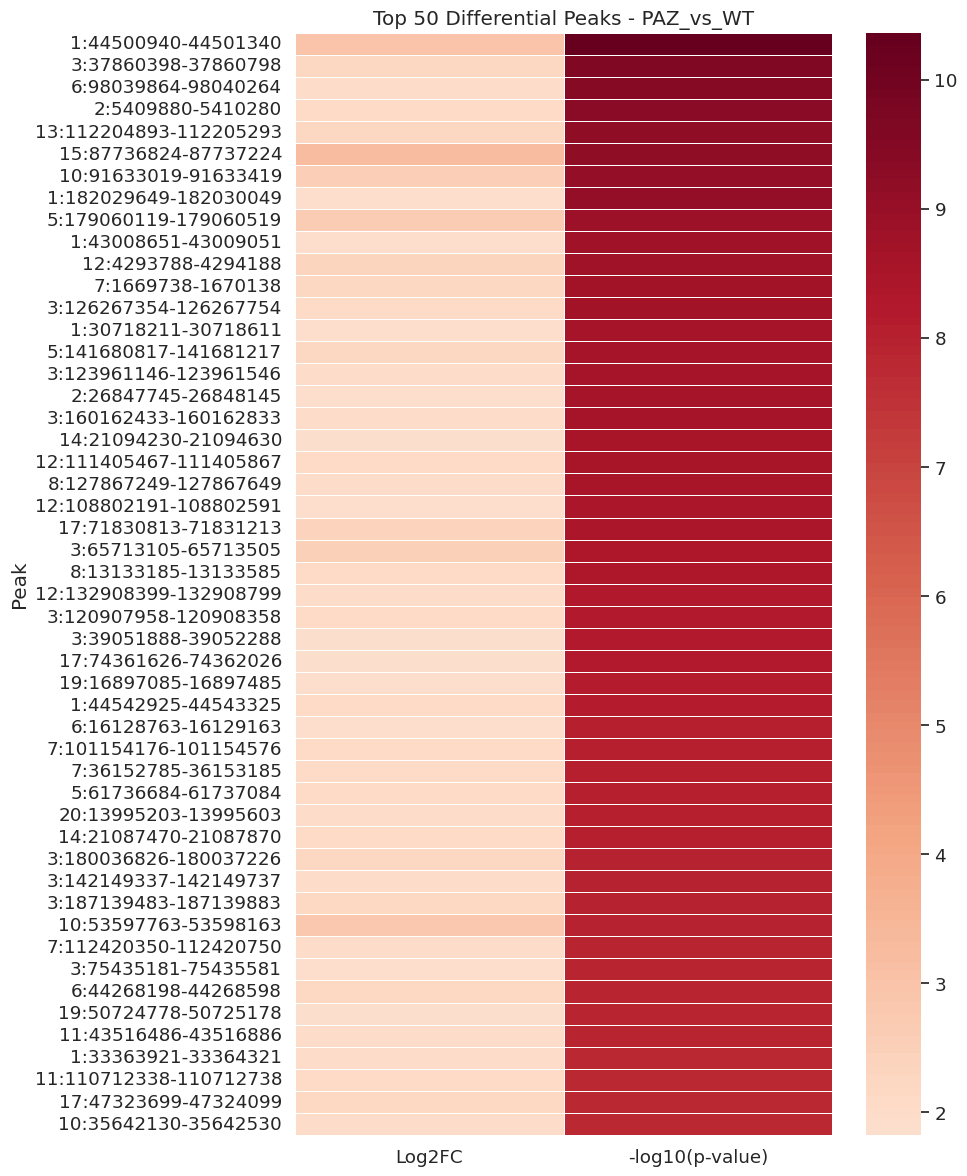

In [51]:
create_heatmap(df, comparison, OUTPUT_DIR)